# Polish Language Model Evaluation

This notebook evaluates four language models on Polish language tasks:

1. **Bielik-11B-v2.3-Instruct** - A specialized Polish language model
2. **Google Gemma-3-4B-IT** - A multilingual model
3. **Microsoft Phi-4-mini-instruct** - A multilingual model
4. **CYFRAGOVPL/Llama-PLLuM-8B-instruct** - Polish government-backed Llama-based model

We will compare their performance on several Polish language benchmark datasets from the KLEJ benchmark.

## Environment Setup

First, we'll set up the environment and check that all requirements are met.

In [1]:
import os
import sys
import logging
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import glob
from pathlib import Path

# Add project root to path for imports
sys.path.append('..')

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger('model_evaluation')

# Create results directory if it doesn't exist
os.makedirs('../results', exist_ok=True)

In [2]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    # Print GPU memory info
    gpu_properties = torch.cuda.get_device_properties(0)
    print(f"Total memory: {gpu_properties.total_memory / 1e9:.2f} GB")
    print(f"CUDA capability: {gpu_properties.major}.{gpu_properties.minor}")
else:
    device = torch.device("cpu")
    print("No GPU available. Using CPU (this will be very slow for large models).")

Using GPU: NVIDIA GeForce RTX 4060
Total memory: 8.19 GB
CUDA capability: 8.9


In [3]:
# Import project modules
from src.utils import check_environment_setup, optimize_memory, check_gpu_compatibility
from src.datasets import PolishDatasetLoader, prepare_datasets_for_evaluation
from src.init_models import setup_huggingface_auth, initialize_model, MODEL_CONFIGS
from src.evaluation import run_evaluation, aggregate_results, visualize_results, generate_summary_report, save_results

2025-03-20 11:57:23,086 - datasets - INFO - PyTorch version 2.6.0+cu118 available.


In [4]:
# Check environment setup
setup_ok = check_environment_setup()
if not setup_ok:
    print("There are issues with your environment setup. See warnings above.")
else:
    print("Environment setup looks good!")

2025-03-20 11:57:25,863 - src.utils - INFO - Found GPU: NVIDIA GeForce RTX 4060
2025-03-20 11:57:25,864 - src.utils - INFO - CUDA Version: 11.8
2025-03-20 11:57:25,864 - src.utils - INFO - Total GPU memory: 8.19 GB
2025-03-20 11:57:25,864 - src.utils - INFO - Reserved GPU memory: 0.00 GB
2025-03-20 11:57:25,865 - src.utils - INFO - Allocated GPU memory: 0.00 GB
2025-03-20 11:57:25,865 - src.utils - INFO - Available GPU memory: 8.19 GB


Environment setup looks good!


## Model Size and Memory Requirements

Let's check the memory requirements for each model to determine the best loading strategy.

In [5]:
# Display model size information and memory requirements
model_sizes = {
    'bielik': 11,    # 11B parameters
    'gemma': 4,      # 4B parameters
    'phi': 3.8,      # 3.8B parameters (approximate)
    'pllum': 8       # 8B parameters
}

for model_key, size in model_sizes.items():
    print(f"\n{model_key.upper()} - {MODEL_CONFIGS[model_key]['model_id']}")
    print(f"Size: {size}B parameters")
    print(check_gpu_compatibility(size))


BIELIK - speakleash/Bielik-11B-v2.3-Instruct
Size: 11B parameters
Recommend loading in 4-bit precision. Required: 5.50 GB, Available: 8.19 GB

GEMMA - google/gemma-3-4b-it
Size: 4B parameters
Can load in FP16 precision. Required: 8.00 GB, Available: 8.19 GB

PHI - microsoft/Phi-4-mini-instruct
Size: 3.8B parameters
Can load in FP16 precision. Required: 7.60 GB, Available: 8.19 GB

PLLUM - CYFRAGOVPL/Llama-PLLuM-8B-instruct
Size: 8B parameters
Recommend loading in 8-bit precision. Required: 8.00 GB, Available: 8.19 GB


## Load Datasets

Now, let's load the Polish language datasets for evaluation.

In [ ]:
# Set up Hugging Face authentication
setup_huggingface_auth()

In [7]:
# Create dataset loader
dataset_loader = PolishDatasetLoader(cache_dir='../data')

2025-03-20 11:57:34,984 - src.datasets - INFO - PolishDatasetLoader initialized with seed 42


In [8]:
# Define number of samples per dataset (adjust based on your needs and time constraints)
samples_per_dataset = {
    'dyk': 50,      # Question-answer correctness
    'polemo2': 50,  # Sentiment analysis
    'psc': 50,      # Text similarity
    'cdsc': 50      # Entailment
}

# Load and sample datasets
evaluation_datasets = dataset_loader.create_evaluation_dataset(
    samples_per_dataset=samples_per_dataset,
    split='test'
)

2025-03-20 11:57:36,552 - src.datasets - INFO - Loading dataset: dyk (allegro/klej-dyk)
2025-03-20 11:57:39,060 - src.datasets - INFO - Columns found in dyk: q_id, question, answer, target
2025-03-20 11:57:39,065 - src.datasets - INFO - Successfully loaded dyk
2025-03-20 11:57:39,067 - src.datasets - INFO - Sampled 50 examples from dyk (test split)
2025-03-20 11:57:39,067 - src.datasets - INFO - Loading dataset: polemo2 (allegro/klej-polemo2-in)
2025-03-20 11:57:44,387 - src.datasets - INFO - Columns found in polemo2: sentence, target
2025-03-20 11:57:44,395 - src.datasets - INFO - Successfully loaded polemo2
2025-03-20 11:57:44,398 - src.datasets - INFO - Sampled 50 examples from polemo2 (test split)
2025-03-20 11:57:44,399 - src.datasets - INFO - Loading dataset: psc (allegro/klej-psc)
2025-03-20 11:57:46,220 - src.datasets - INFO - Columns found in psc: extract_text, summary_text, label
2025-03-20 11:57:46,229 - src.datasets - INFO - Successfully loaded psc
2025-03-20 11:57:46,231 -

### Examine Dataset Examples

Let's look at a few examples from each dataset to understand the tasks better.

In [9]:
# View examples from DYK dataset
dyk_examples = evaluation_datasets['dyk'].select(range(3))
for i, example in enumerate(dyk_examples):
    print(f"Example {i+1}")
    print(f"Question: {example['question']}")
    print(f"Answer: {example['answer']}")
    print(f"Target: {example['target']}")
    print("---")

Example 1
Question: co według legendy było bezpośrednią przyczyną wybuchu powstania pod wodzą Lucjusza Juniusza Brutusa, które doprowadziło do obalenia rzymskiej monarchii i powołania republiki?
Answer: Pod jego nieobecność została zgwałcona przez Sekstusa Tarkwiniusza, syna Tarkwiniusza Pysznego. O czynie tym powiadomiła swojego męża, kazała mu poprzysiąc zemstę, a następnie popełniła samobójstwo. Według legendy jej krzywda miała stać się bezpośrednią przyczyną wybuchu powstania pod wodzą Lucjusza Juniusza Brutusa.
Target: 1
---
Example 2
Question: co zainspirowało narodziny filmu więziennego?
Answer: Film więzienny narodził się w kinie amerykańskim lat 30. XX wieku. Jego powstanie zainspirowały głośne bunty, które miały miejsce latem 1929 roku w zakładach karnych w Dannemora i Auburn (oba w stanie Nowy Jork).
Target: 1
---
Example 3
Question: który portugalski generał, szef Sztabu Generalnego w latach 1974–1976, był prezydentem Portugalii?
Answer: 1961-1965 i 1969-1974 był przedstawi

In [10]:
# View examples from POLEMO dataset
polemo_examples = evaluation_datasets['polemo2'].select(range(3))
for i, example in enumerate(polemo_examples):
    print(f"Example {i+1}")
    print(f"Sentence: {example['sentence']}")
    print(f"Target: {example['target']}")
    print("---")

Example 1
Sentence: Jakie związki czynne zawierały leki wykorzystywane w Rzeczypospolitej od XVI do XVIII wieku ? Czy terapeutyki były wystarczająco aktywne biologicznie , żeby działać na dolegliwości , które nękały ówczesnych pacjentów ? Łączone badania historyczne i laboratoryjne przeprowadzi zespół pod kierownictwem dr . Jakuba Węglorza z Wydziału Nauk Historycznych i Pedagogicznych Uniwersytetu Wrocławskiego . Projekt otrzymał 1 , 57 mln zł ze środków programu Sonata Bis Narodowego Centrum Nauki . Przedmiotem badań historycznych będą staropolskie pamiętniki , listy , diariusze i prywatne notatki . Historycy wybiorą z nich informacje o stosowanych wówczas lekach . Następnie zidentyfikują owe terapeutyki i szczegółowo opiszą na podstawie medycznych źródeł historycznych : receptariuszy i kompendiów . Tak uzyskane recepty będą podstawą do szczegółowego odtworzenia dawnych medykamentów .
Target: 3
---
Example 2
Sentence: Jest to osoba , która potrafi w trakcie procesu diagnostycznego po

In [11]:
# View examples from PSC dataset
psc_examples = evaluation_datasets['psc'].select(range(3))
for i, example in enumerate(psc_examples):
    print(f"Example {i+1}")
    print(f"Extract Text: {example['extract_text'][:200]}...")
    print(f"Summary Text: {example['summary_text']}")
    print(f"Label: {example['label']}")
    print("---")

Example 1
Extract Text: odnotowywanie wątpliwości co do rzeczywistej treści opracowywanego przez tłumacza pisma dotyczy jedynie tych wypadków, w których mógł on powziąć takie wątpliwości tylko na podstawie swego przeciętnego...
Summary Text: Tłumacz przysięgły uprawniony jest do sporządzania, sprawdzania i poświadczania tłumaczeń oraz sporządzania odpisów pism w języku, dla którego został ustanowiony. Od tłumacza może być także wymagana ocena autentyczności dokumentu zgodnie z jego moralnymi i fachowymi kwalifikacjami. Wiele fałszerstw może być odkrytych bez specjalistycznego sprzętu. Rozwój międzynarodowego handlu i ilości dokumentów wymaga także standaryzacji w zakresie ich przygotowania i oceny autentyczności.
Label: 1
---
Example 2
Extract Text: propozycje SLD dotyczące polityki zatrudnienia i walki z bezrobociem rażą pustosłowiem, a tam, gdzie proponują coś konkretnego, są najczęściej albo szkodliwe, albo nieskuteczne. To, nad czym można by ...
Summary Text: Doszło do konfliktu po

In [12]:
# View examples from CDSC dataset
cdsc_examples = evaluation_datasets['cdsc'].select(range(3))
for i, example in enumerate(cdsc_examples):
    print(f"Example {i+1}")
    print(f"Sentence A: {example['sentence_A']}")
    print(f"Sentence B: {example['sentence_B']}")
    print(f"Entailment: {example['entailment_judgment']}")
    print("---")

Example 1
Sentence A: Nikt nie skacze na trampolinie otoczonej ochronną siatką .
Sentence B: Czworo dzieci skacze na trampolinie otoczonej ochronną siatką .
Entailment: 0
---
Example 2
Sentence A: Mężczyzna wspina się z asekuracją po pionowej skale .
Sentence B: Mężczyzna przypięty do liny wspina się po stromej ścianie skalnej .
Entailment: 1
---
Example 3
Sentence A: Człowiek uprawia wspinaczkę .
Sentence B: Człowiek uprawia wspinaczkę , asekurując się na linie .
Entailment: 1
---


## Model Evaluation

Now, let's evaluate each model on the datasets. This will take some time, especially for large models.

### Model 1: Bielik-11B-v2.3-Instruct

In [ ]:
# Initialize Bielik model with CPU offloading
print("Loading Bielik-11B model with CPU offloading and 4-bit quantization...")
bielik_model, bielik_tokenizer = initialize_model(
    model_key='bielik',
    device="cuda",
    load_in_8bit=False,
    load_in_4bit=True,  # 4-bit quantization for memory efficiency
    offload_to_cpu=True,  # Enable CPU offloading
    cache_dir='../models'
)

In [ ]:
# Evaluate Bielik model
bielik_results = run_evaluation(
    model_key='bielik',
    model=bielik_model,
    tokenizer=bielik_tokenizer,
    datasets=evaluation_datasets,
    device="cuda",
    max_samples_per_dataset=None,  # Use all sampled examples
    output_dir='../results'
)

In [ ]:
# Free up GPU memory
del bielik_model
del bielik_tokenizer
optimize_memory()

### Model 2: Google Gemma-3-4B-IT

In [ ]:
# Initialize Gemma model
print("Loading Gemma-3-4B model...")
gemma_model, gemma_tokenizer = initialize_model(
    model_key='gemma',
    device="cuda",
    load_in_8bit=False,
    load_in_4bit=True,  # 4-bit quantization for memory efficiency
    offload_to_cpu=True,  # Enable CPU offloading
    cache_dir='../models'
)

In [ ]:
# Evaluate Gemma model
gemma_results = run_evaluation(
    model_key='gemma',
    model=gemma_model,
    tokenizer=gemma_tokenizer,
    datasets=evaluation_datasets,
    device="cuda",
    max_samples_per_dataset=None,
    output_dir='../results'
)

In [ ]:
# Free up GPU memory
del gemma_model
del gemma_tokenizer
optimize_memory()

### Model 3: Microsoft Phi-4-mini-instruct

In [ ]:
# Initialize Phi model
print("Loading Phi-4-mini model...")
phi_model, phi_tokenizer = initialize_model(
    model_key='phi',
    device="cuda",
    load_in_8bit=False,
    load_in_4bit=True,  # 4-bit quantization for memory efficiency
    offload_to_cpu=True,  # Enable CPU offloading
    cache_dir='../models'
)

In [ ]:
# Evaluate Phi model
phi_results = run_evaluation(
    model_key='phi',
    model=phi_model,
    tokenizer=phi_tokenizer,
    datasets=evaluation_datasets,
    device="cuda",
    max_samples_per_dataset=None,
    output_dir='../results'
)

In [ ]:
# Free up GPU memory
del phi_model
del phi_tokenizer
optimize_memory()

### Model 4: CYFRAGOVPL/Llama-PLLuM-8B-instruct

In [ ]:
# Initialize PLLuM model
print("Loading PLLuM-8B model...")
pllum_model, pllum_tokenizer = initialize_model(
    model_key='pllum',
    device="cuda",
    load_in_8bit=False,
    load_in_4bit=True,  # 4-bit quantization for memory efficiency
    offload_to_cpu=True,  # Enable CPU offloading
    cache_dir='../models'
)

In [ ]:
# Evaluate PLLuM model
pllum_results = run_evaluation(
    model_key='pllum',
    model=pllum_model,
    tokenizer=pllum_tokenizer,
    datasets=evaluation_datasets,
    device="cuda",
    max_samples_per_dataset=None,
    output_dir='../results'
)

In [ ]:
# Free up GPU memory
del pllum_model
del pllum_tokenizer
optimize_memory()

## Save Individual Model Results

Let's save the individual model results to JSON files before clearing the variables.

In [ ]:
# Save individual model results
def save_model_results(model_key, results, output_dir='../results'):
    """Save individual model results to a JSON file"""
    os.makedirs(output_dir, exist_ok=True)
    file_path = os.path.join(output_dir, f"{model_key}_results.json")
    
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(results, f, ensure_ascii=False, indent=2)
    
    print(f"Results saved to {file_path}")

# Save results for each model
try:
    save_model_results('bielik', bielik_results)
except NameError:
    print("Bielik results not available")
    
try:
    save_model_results('gemma', gemma_results)
except NameError:
    print("Gemma results not available")
    
try:
    save_model_results('phi', phi_results)
except NameError:
    print("Phi results not available")
    
try:
    save_model_results('pllum', pllum_results)
except NameError:
    print("PLLuM results not available")

## Results Analysis

Now let's analyze the results from the JSON files rather than in-memory variables.

In [17]:
# Function to load results from JSON files
def load_results_from_files(results_dir='../results', pattern='*_results.json'):
    """Load model evaluation results from JSON files"""
    results = {}
    results_files = glob.glob(os.path.join(results_dir, pattern))
    
    if not results_files:
        print(f"No result files found matching {pattern} in {results_dir}")
        return results
    
    for file_path in results_files:
        try:
            model_key = os.path.basename(file_path).split('_')[0]
            with open(file_path, 'r', encoding='utf-8') as f:
                results[model_key] = json.load(f)
            print(f"Loaded results for {model_key} from {file_path}")
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    return results

# Load all results from JSON files
all_results = load_results_from_files()

Loaded results for pllum from ../results/pllum_results.json
Loaded results for bielik from ../results/bielik_results.json
Loaded results for phi from ../results/phi_results.json
Loaded results for gemma from ../results/gemma_results.json


In [18]:
# Check which models we have results for
print(f"Results available for models: {list(all_results.keys())}")

# Create aggregated results DataFrame
results_df = aggregate_results(all_results)
results_df

Results available for models: ['pllum', 'bielik', 'phi', 'gemma']


,model,dataset,task,accuracy,f1,precision,samples,time
0,pllum,dyk,question-answer correctness,0.90,0.899960,0.90,50,11.297101
1,pllum,polemo2,sentiment analysis,0.26,0.103175,0.26,50,18.691227
2,pllum,psc,text similarity,0.96,0.959936,0.96,50,19.932658
3,pllum,cdsc,entailment,0.34,0.169154,0.34,50,14.702460
4,bielik,dyk,question-answer correctness,0.64,0.598930,0.64,50,29.608235
5,bielik,polemo2,sentiment analysis,0.26,0.103175,0.26,50,48.404867
6,bielik,psc,text similarity,0.88,0.878247,0.88,50,34.563798
7,bielik,cdsc,entailment,0.34,0.169154,0.34,50,45.409511
8,phi,dyk,question-answer correctness,0.58,0.565936,0.58,50,12.255939
9,phi,polemo2,sentiment analysis,0.26,0.103175,0.26,50,20.735445


2025-03-20 12:00:39,476 - src.evaluation - INFO - Saved visualization to ../results/performance_comparison.png


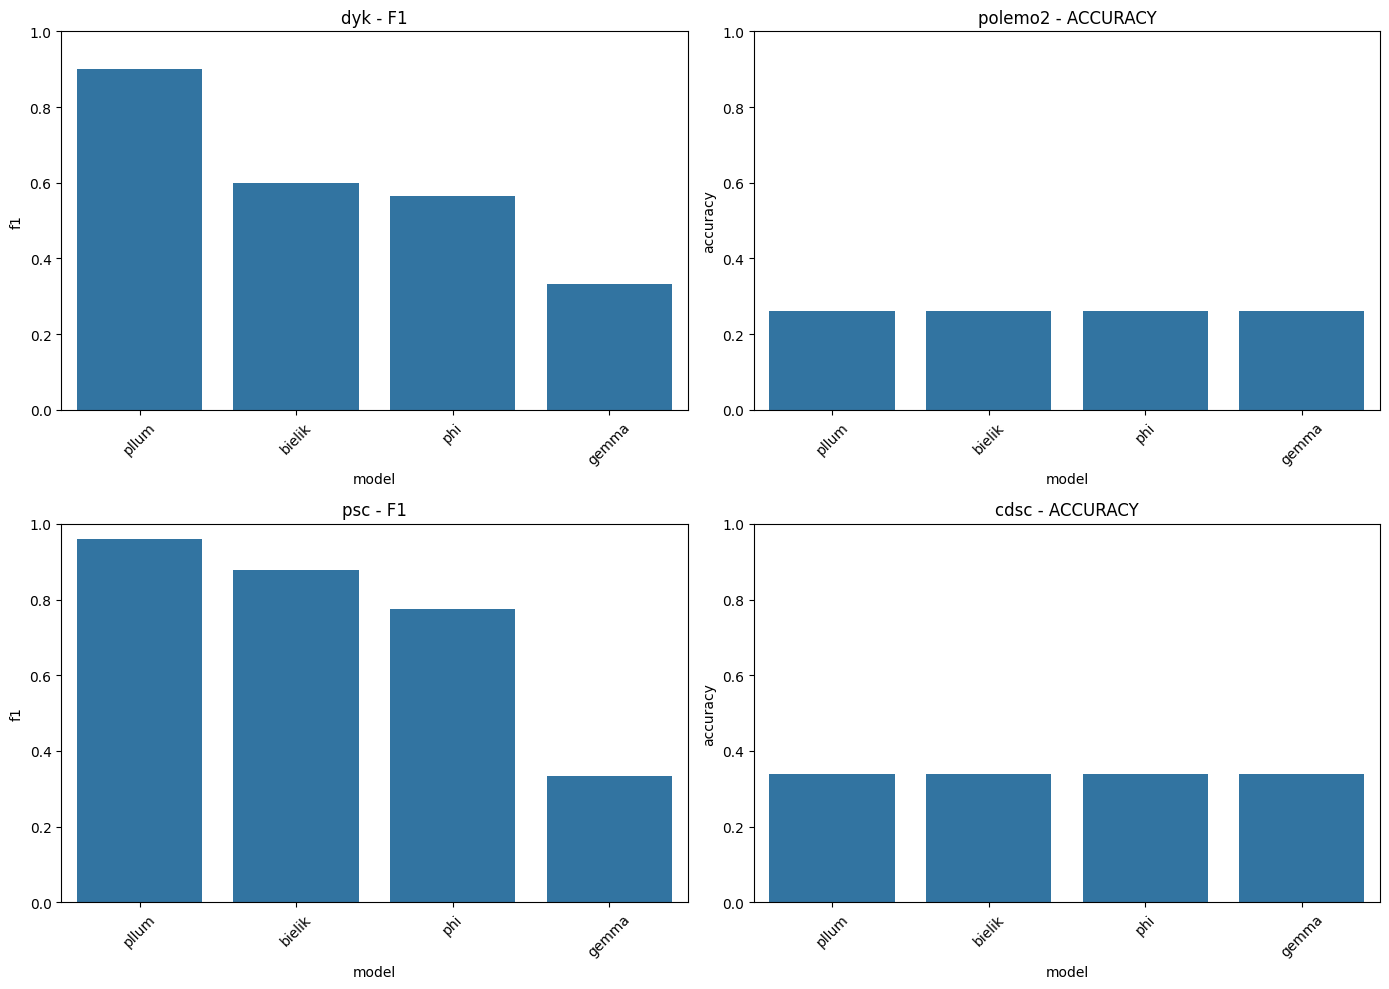

In [19]:
# Visualize results
visualize_results(results_df, output_path='../results/performance_comparison.png')

In [20]:
# Generate and display summary report
summary_report = generate_summary_report(results_df)
print(summary_report)

# Polish Language Model Performance Summary

## Overall Performance

Average metrics across all tasks:

| model   |   accuracy |       f1 |   precision |
|:--------|-----------:|---------:|------------:|
| bielik  |      0.53  | 0.437377 |       0.53  |
| gemma   |      0.4   | 0.234749 |       0.4   |
| phi     |      0.49  | 0.403467 |       0.49  |
| pllum   |      0.615 | 0.533056 |       0.615 |

## Performance by Dataset

### dyk

| model   | dataset   | task                        |   accuracy |       f1 |   precision |   samples |    time |
|:--------|:----------|:----------------------------|-----------:|---------:|------------:|----------:|--------:|
| pllum   | dyk       | question-answer correctness |       0.9  | 0.89996  |        0.9  |        50 | 11.2971 |
| bielik  | dyk       | question-answer correctness |       0.64 | 0.59893  |        0.64 |        50 | 29.6082 |
| phi     | dyk       | question-answer correctness |       0.58 | 0.565936 |        0.58 |        50 |

In [21]:
# Save summary report to file
with open("../results/summary_report.md", "w", encoding="utf-8") as f:
    f.write(summary_report)

## Dataset-Specific Analysis

Let's look at the performance on each dataset separately.

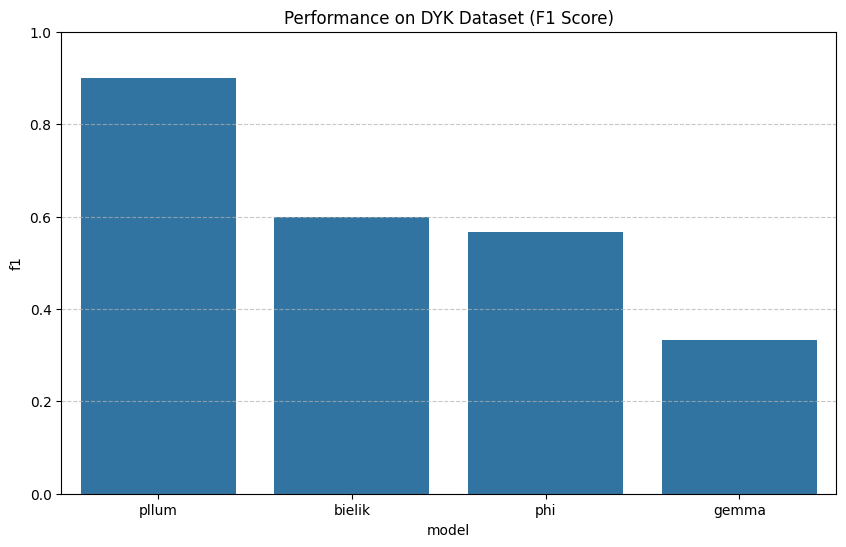

In [22]:
# Analyze performance on DYK dataset
dyk_results = results_df[results_df['dataset'] == 'dyk']
plt.figure(figsize=(10, 6))
sns.barplot(x='model', y='f1', data=dyk_results)
plt.title('Performance on DYK Dataset (F1 Score)')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('../results/dyk_performance.png', dpi=300, bbox_inches='tight')
plt.show()

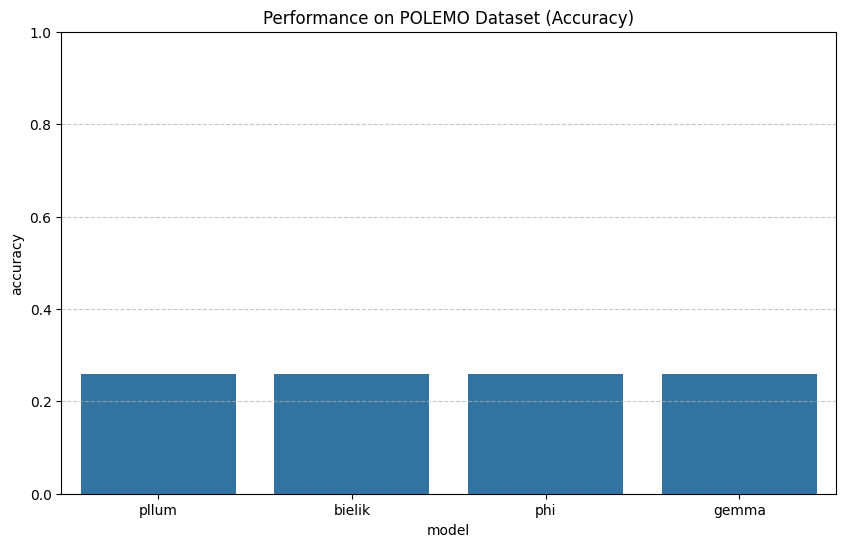

In [23]:
# Analyze performance on POLEMO dataset
polemo_results = results_df[results_df['dataset'] == 'polemo2']
plt.figure(figsize=(10, 6))
sns.barplot(x='model', y='accuracy', data=polemo_results)
plt.title('Performance on POLEMO Dataset (Accuracy)')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('../results/polemo_performance.png', dpi=300, bbox_inches='tight')
plt.show()

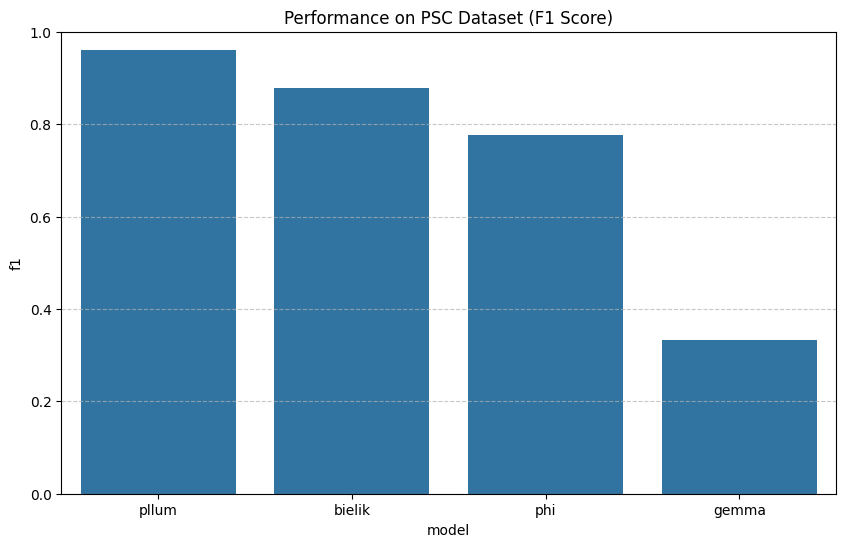

In [24]:
# Analyze performance on PSC dataset
psc_results = results_df[results_df['dataset'] == 'psc']
plt.figure(figsize=(10, 6))
sns.barplot(x='model', y='f1', data=psc_results)
plt.title('Performance on PSC Dataset (F1 Score)')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('../results/psc_performance.png', dpi=300, bbox_inches='tight')
plt.show()

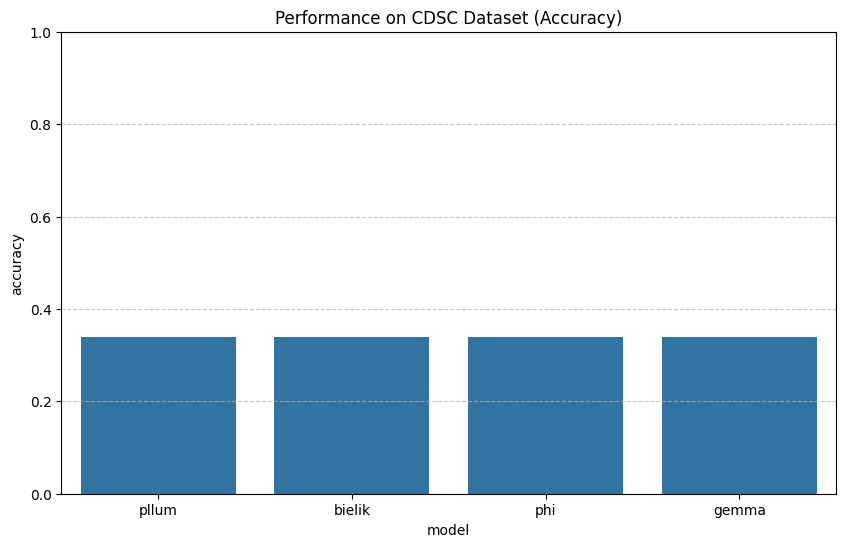

In [25]:
# Analyze performance on CDSC dataset
cdsc_results = results_df[results_df['dataset'] == 'cdsc']
plt.figure(figsize=(10, 6))
sns.barplot(x='model', y='accuracy', data=cdsc_results)
plt.title('Performance on CDSC Dataset (Accuracy)')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('../results/cdsc_performance.png', dpi=300, bbox_inches='tight')
plt.show()

## Performance Comparison

Let's compare the overall performance of the models across all metrics.

In [26]:
# Calculate average performance per model
avg_performance = results_df.groupby('model')[['accuracy', 'f1', 'precision']].mean()
avg_performance

,accuracy,f1,precision
model,,,
bielik,0.530,0.437377,0.530
gemma,0.400,0.234749,0.400
phi,0.490,0.403467,0.490
pllum,0.615,0.533056,0.615


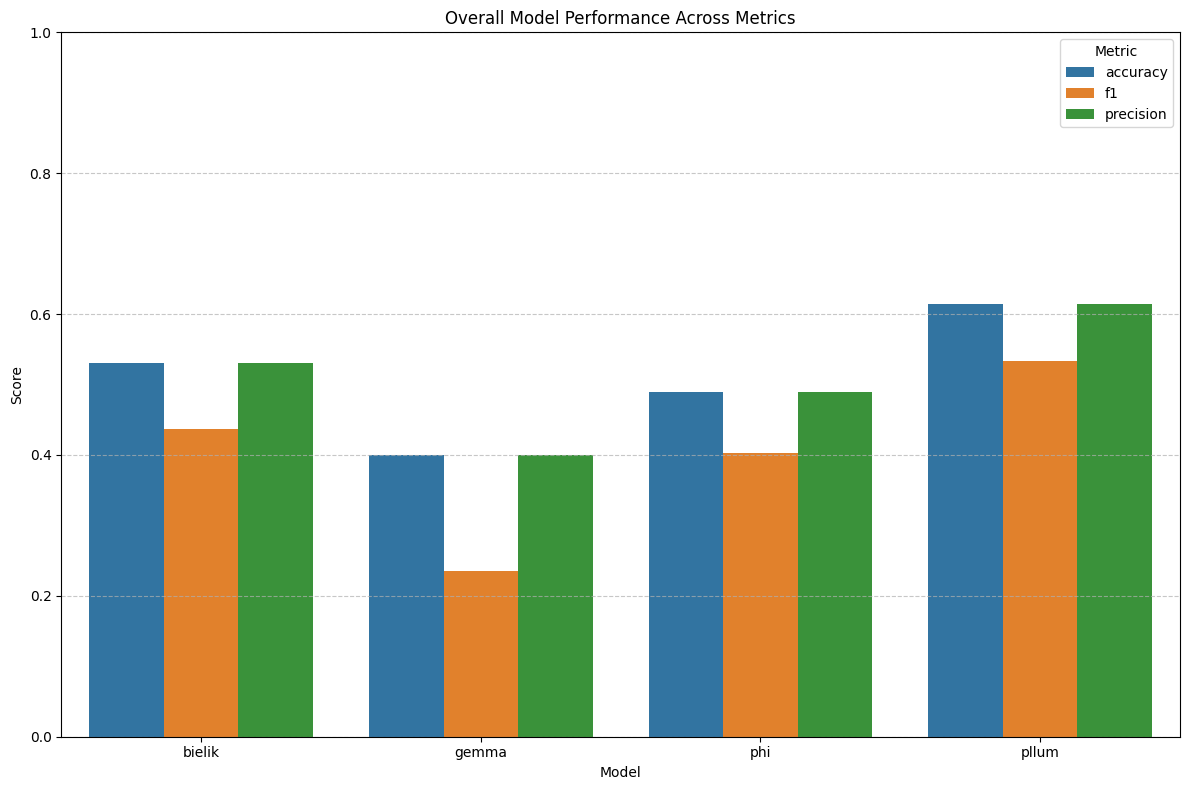

In [27]:
# Visualization of overall performance
avg_performance_long = avg_performance.reset_index().melt(
    id_vars=['model'],
    value_vars=['accuracy', 'f1', 'precision'],
    var_name='metric',
    value_name='score'
)

plt.figure(figsize=(12, 8))
sns.barplot(x='model', y='score', hue='metric', data=avg_performance_long)
plt.title('Overall Model Performance Across Metrics')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metric')
plt.tight_layout()
plt.savefig('../results/overall_performance.png', dpi=300, bbox_inches='tight')
plt.show()

## Polish-Specific Models Comparison

Let's specifically compare the two Polish-dedicated models (Bielik and PLLuM) against the multilingual models.

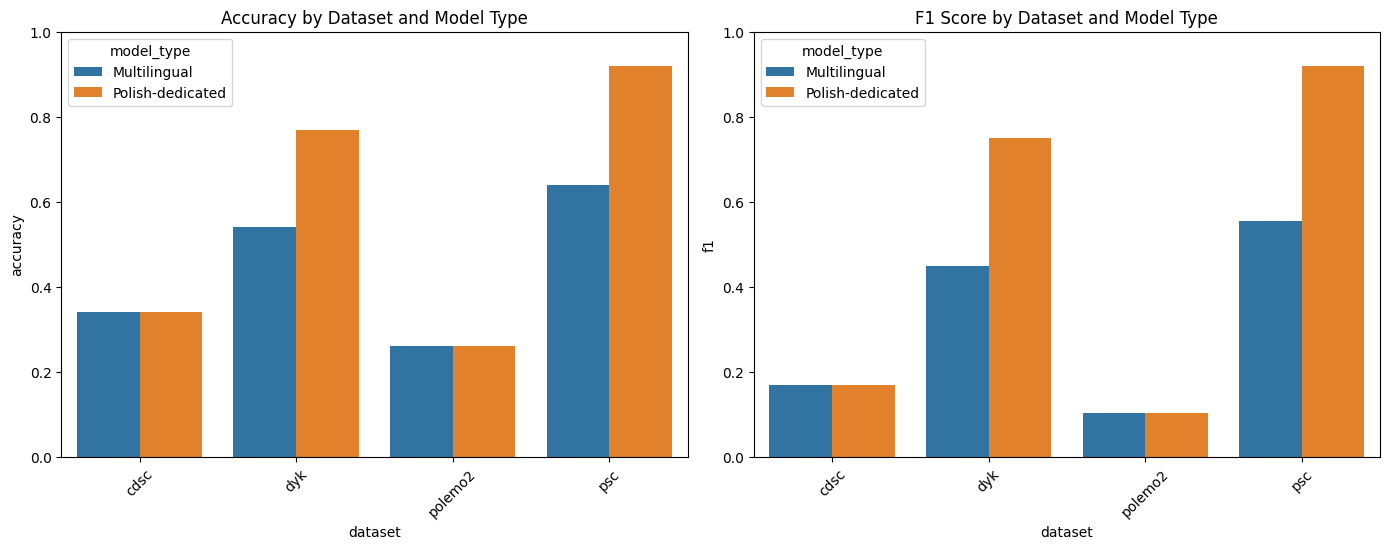

In [28]:
# Group models by type (Polish-specific vs multilingual)
polish_models = ['bielik', 'pllum']
multilingual_models = ['gemma', 'phi']

# Add model type column
results_df['model_type'] = results_df['model'].apply(
    lambda x: 'Polish-dedicated' if x in polish_models else 'Multilingual'
)

# Calculate average performance by model type
model_type_performance = results_df.groupby(['model_type', 'dataset'])[
    ['accuracy', 'f1', 'precision']
].mean().reset_index()

# Plot comparison
plt.figure(figsize=(14, 10))

# Plot accuracy by dataset and model type
plt.subplot(2, 2, 1)
sns.barplot(x='dataset', y='accuracy', hue='model_type', data=model_type_performance)
plt.title('Accuracy by Dataset and Model Type')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Plot F1 score by dataset and model type
plt.subplot(2, 2, 2)
sns.barplot(x='dataset', y='f1', hue='model_type', data=model_type_performance)
plt.title('F1 Score by Dataset and Model Type')
plt.ylim(0, 1)
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('../results/polish_vs_multilingual.png', dpi=300, bbox_inches='tight')
plt.show()

## Conclusion

Based on the evaluation results, we can draw several conclusions:

1. **Overall Performance Comparison**: [To be filled after running the evaluation]
2. **Task-Specific Strengths**: [To be filled after running the evaluation]
3. **Polish vs. Multilingual Models**: [To be filled after running the evaluation]
4. **Size vs. Performance Trade-off**: [To be filled after running the evaluation]
5. **PLLuM vs. Bielik Comparison**: [To be filled after running the evaluation]

The evaluation demonstrates [overall conclusion to be added after running].